In [2]:
# Import the relevant Python libraries.
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration4_Abhishek').getOrCreate()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
# Firsht installed pip on python to import seaborn*****NOTE

# sudo apt-get install -y python3-dev python3-setuptools
#sudo apt-get update
#sudo apt-get install python3-pip
#pip3 install -U pip
#pip install seaborn --user
import seaborn as sns



# Let's read in the data.
air_data = spark.read.csv('./data.csv', header = True,inferSchema=True)

# The show method allows us to visualise DataFrames.
air_data.show(10)

# Let's have a look at the column names. 
columns = air_data.columns
columns

# Select a list of relevant columns. 
air_data = air_data.drop("stn_code","agency","sampling_date","location_monitoring_station")
#air_data = air_data.select(air_data.state.cast("String"))
#air_data.printSchema()

   # Let's import in the relevant types.


+--------+------------------+--------------+---------+------+--------------------+----+-----+----+----+---------------------------+-----+--------+
|stn_code|     sampling_date|         state| location|agency|                type| so2|  no2|rspm| spm|location_monitoring_station|pm2_5|    date|
+--------+------------------+--------------+---------+------+--------------------+----+-----+----+----+---------------------------+-----+--------+
|     150|February - M021990|Andhra Pradesh|Hyderabad|    NA|Residential, Rura...|4.80|17.40|null|null|                         NA| null|2/1/1990|
|     151|February - M021990|Andhra Pradesh|Hyderabad|    NA|     Industrial Area|3.10| 7.00|null|null|                         NA| null|2/1/1990|
|     152|February - M021990|Andhra Pradesh|Hyderabad|    NA|Residential, Rura...|6.20|28.50|null|null|                         NA| null|2/1/1990|
|     150|   March - M031990|Andhra Pradesh|Hyderabad|    NA|Residential, Rura...|6.30|14.70|null|null|               

In [3]:
from pyspark.sql.types import (StructField,StringType,IntegerType,DateType,ShortType,DoubleType,StructType)

# Then create a variable with the correct structure.
air_data2 = air_data.select(air_data.state,air_data.type,air_data.location,air_data.so2.cast("Integer"),air_data.no2.cast("Integer"),air_data.spm.cast("Integer"),
                            air_data.rspm.cast("Integer"),air_data.pm2_5.cast("Integer"),air_data.date.cast("Date"))
#airdata2=airdata.select(air_data2.Date)
air_data2.printSchema()

air_data2.limit(5941).toPandas()

finalairdata=air_data2.na.fill(0,subset=['spm','rspm','so2','no2','pm2_5'])
#finalairdata=air_data2.na.fill('Nodate',subset=['date'])
finalairdata.show()
for item in finalairdata.columns:
    nullCount=finalairdata.where(F.col(item).isNull()).count()
    print("Number of null values for " + item + " = %g" % nullCount)


root
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- so2: integer (nullable = true)
 |-- no2: integer (nullable = true)
 |-- spm: integer (nullable = true)
 |-- rspm: integer (nullable = true)
 |-- pm2_5: integer (nullable = true)
 |-- date: date (nullable = true)

+--------------+--------------------+---------+---+---+---+----+-----+----+
|         state|                type| location|so2|no2|spm|rspm|pm2_5|date|
+--------------+--------------------+---------+---+---+---+----+-----+----+
|Andhra Pradesh|Residential, Rura...|Hyderabad|  4| 17|  0|   0|    0|null|
|Andhra Pradesh|     Industrial Area|Hyderabad|  3|  7|  0|   0|    0|null|
|Andhra Pradesh|Residential, Rura...|Hyderabad|  6| 28|  0|   0|    0|null|
|Andhra Pradesh|Residential, Rura...|Hyderabad|  6| 14|  0|   0|    0|null|
|Andhra Pradesh|     Industrial Area|Hyderabad|  4|  7|  0|   0|    0|null|
|Andhra Pradesh|Residential, Rura...|Hyderabad|  6| 25| 

In [4]:
# Type conversion
# Select a list of relevant columns we dont need date we droped date here. 
my_cols = finalairdata.select([
 'state',
'so2',
 'no2',
 'rspm',
 'spm',
 'pm2_5',
 'type',
 ])
air_quality=my_cols

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

# First create a string indexer (convert every string into a number, such as male = 0 and female = 1).
# A number will be assigned to every category in the column.
type_indexer = StringIndexer(inputCol='type',outputCol='typeIndex').fit(air_quality)
air_quality= type_indexer.transform(air_quality)

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# This makes it easier to process when you have multiple classes.
air_quality = OneHotEncoder(inputCol='typeIndex',outputCol='typeVec').transform(air_quality)

# First create a string indexer (convert every string into a number, such as male = 0 and female = 1).
# A number will be assigned to every category in the column.
type_indexer = StringIndexer(inputCol='state',outputCol='stateIndex').fit(air_quality)
air_quality= type_indexer.transform(air_quality)

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# This makes it easier to process when you have multiple classes.
air_quality = OneHotEncoder(inputCol='stateIndex',outputCol='stateVec').transform(air_quality)



In [5]:
# algo starts here
air_quality= air_quality.withColumn('logspm', F.log('spm'))

air_quality.columns

#air_quality.show()
# to view statistical information of the selected column(s)
air_quality.describe('logspm').toPandas()

air_quality.drop('logso2','logspm')


DataFrame[state: string, so2: int, no2: int, rspm: int, spm: int, pm2_5: int, type: string, typeIndex: double, typeVec: vector, stateIndex: double, stateVec: vector]

In [6]:
# The input columns are the feature columns names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=[
     'so2',
     'typeVec',
     'no2',
     'spm',
     'pm2_5',
     'stateVec'],
    outputCol="patterns")

#randomly split data into training and test dataset
(train_data, test_data) = air_quality.randomSplit([0.7, 0.3], seed = 111)

In [7]:
#Linear Regression Starts from here




lr_train_data = assembler.transform(train_data)
lr_test_data = assembler.transform(test_data)
lr_train_data .show(5000)

# importing LinearRegression
from pyspark.ml.regression import LinearRegression
# These are the default values:
# featuresCol: What is the features column named? 
# labelCol: What is the label column named?
# predictionCol: What is the name of the actual prediction?


lr = LinearRegression(featuresCol='patterns', labelCol='spm', predictionCol='prediction')
# Fit/train the model. Fit the model onto the training data.
lrModel = lr.fit(lr_train_data)
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))






+--------------+---+---+----+---+-----+--------------------+---------+--------------+----------+--------------+------------------+--------------------+
|         state|so2|no2|rspm|spm|pm2_5|                type|typeIndex|       typeVec|stateIndex|      stateVec|            logspm|            patterns|
+--------------+---+---+----+---+-----+--------------------+---------+--------------+----------+--------------+------------------+--------------------+
|Andhra Pradesh|  0|  0|   0|  0|    0|     Industrial Area|      1.0|(10,[1],[1.0])|       2.0|(36,[2],[1.0])|              null|(50,[2,16],[1.0,1...|
|Andhra Pradesh|  0|  0|   0|  0|    0|     Industrial Area|      1.0|(10,[1],[1.0])|       2.0|(36,[2],[1.0])|              null|(50,[2,16],[1.0,1...|
|Andhra Pradesh|  0|  0|   0|  0|    0|     Industrial Area|      1.0|(10,[1],[1.0])|       2.0|(36,[2],[1.0])|              null|(50,[2,16],[1.0,1...|
|Andhra Pradesh|  0|  0|   0|  0|    0|     Industrial Area|      1.0|(10,[1],[1.0])|   

In [8]:
# Let's evaluate the model against the test data.
lr_train_results = lrModel.evaluate(lr_train_data)

# Interesting results! This shows the difference between the predicted value and the test data.
lr_train_results.residuals.show(10)

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Mean Absolute Error (mae) on train data: {}".format(lr_train_results.meanAbsoluteError))

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Mean Squared Error (mse) on train data: {}".format(lr_train_results.meanSquaredError))


# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Root Mean Squared Error (rmse) on train data: {}".format(lr_train_results.rootMeanSquaredError))
# We can also get the R2 value. 
print("R Squared (R2) on test data: {}".format(lr_train_results.r2))


+--------------------+
|           residuals|
+--------------------+
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on train data: 2.210462614294795e-14
Mean Squared Error (mse) on train data: 1.0587199860000506e-27
Root Mean Squared Error (rmse) on train data: 3.2537977595419947e-14
R Squared (R2) on test data: 1.0


In [9]:

# Let's evaluate the model against the test data.
lr_test_results = lrModel.evaluate(lr_test_data)

# Interesting results! This shows the difference between the predicted value and the test data.
lr_test_results.residuals.show(10)

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Mean Absolute Error (mae) on test data: {}".format(lr_test_results.meanAbsoluteError))

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Mean Squared Error (mse) on test data: {}".format(lr_test_results.meanSquaredError))


# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("Root Mean Squared Error (rmse) on test data: {}".format(lr_test_results.rootMeanSquaredError))

# We can also get the R2 value. 
print("R Squared (R2) on test data: {}".format(lr_test_results.r2))



+--------------------+
|           residuals|
+--------------------+
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-1.56541446472147...|
|-5.70654634657330...|
|-5.70654634657330...|
|-3.74145159298677...|
+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data: 6.1070285931577175e-06
Mean Squared Error (mse) on test data: 4.86631842296532e-06
Root Mean Squared Error (rmse) on test data: 0.002205973350465803
R Squared (R2) on test data: 0.99999999978409


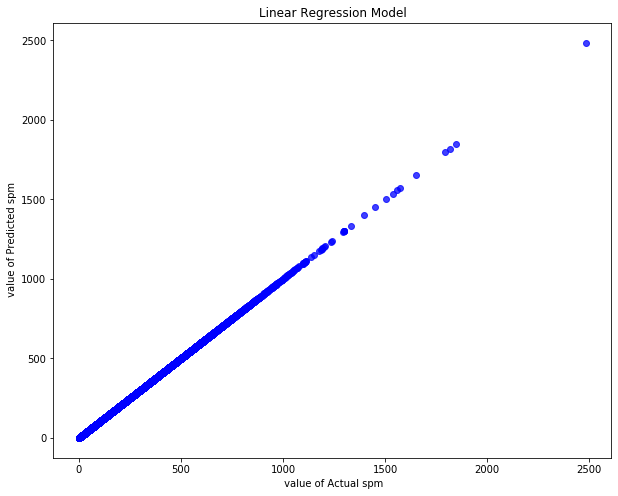

In [10]:

#view this relationship between predictions and actual_values graphically with a scatter plot.

lr_PriceArr = np.array(lr_test_results.predictions.select('spm').collect())
lr_PredictionArr = np.array(lr_test_results.predictions.select('Prediction').collect())

plt.figure(figsize=(10,8))
plt.scatter(lr_PriceArr,lr_PredictionArr, alpha=.75,
            color='b')  # alpha helps to show overlapping data
 
plt.xlabel(' value of Actual spm')
plt.ylabel(' value of Predicted spm')
plt.title('Linear Regression Model')

plt.show()


In [11]:
# Random forest Regression start from here
#importing Random Forest Regression
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics# Useing the model on train data to view the result of the model on train data

#rf_train_results = rf_model.transform(train_data)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# train RandomForest model
rf = RandomForestRegressor(labelCol="spm", featuresCol="patterns", predictionCol = "prediction")

rf_pipeline = Pipeline(stages=[assembler, rf])
# creating the Random forest model
rf_model = rf_pipeline.fit(train_data)


In [12]:
# Useing the model on train data to view the result of the model on train data

rf_train_results = rf_model.transform(train_data)

# Let's have a look into the predictions on the traindata from model.
rf_train_results.select('spm','prediction', 'patterns').show(10)


rf_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on train data = %g" %rf_evaluator.evaluate(rf_train_results,{rf_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on train data = %g" %rf_evaluator.evaluate(rf_train_results,{rf_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on train data = %g" %rf_evaluator.evaluate(rf_train_results,{rf_evaluator.metricName: "rmse"}))

print("R Squared (R2) on train data = %g" %rf_evaluator.evaluate(rf_train_results,{rf_evaluator.metricName: "r2"}))


+---+-----------------+--------------------+
|spm|       prediction|            patterns|
+---+-----------------+--------------------+
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
|  0|21.84891940872076|(50,[2,16],[1.0,1...|
+---+-----------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on train data = 25.7987
Mean Squared Error (mse) on train data = 2377.15
Root Mean Squared Error (rmse) on train data = 48.756
R Squared (R2) on train data = 0.894401


In [13]:
# Make predictions on test data
rf_test_results = rf_model.transform(test_data)

# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
rf_test_results.select('spm','prediction', 'patterns').show(10)



rf_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on test data = %g" %rf_evaluator.evaluate(rf_test_results,{rf_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on test data = %g" %rf_evaluator.evaluate(rf_test_results,{rf_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on test data = %g" %rf_evaluator.evaluate(rf_test_results,{rf_evaluator.metricName: "rmse"}))

print("R Squared (R2) on test data = %g" %rf_evaluator.evaluate(rf_test_results,{rf_evaluator.metricName: "r2"}))


+---+------------------+--------------------+
|spm|        prediction|            patterns|
+---+------------------+--------------------+
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 21.84891940872076|(50,[2,16],[1.0,1...|
|  0| 62.23901083821694|(50,[4,16],[1.0,1...|
|  0| 62.23901083821694|(50,[4,16],[1.0,1...|
|  0|40.270563351366626|(50,[7,16],[1.0,1...|
+---+------------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data = 25.7556
Mean Squared Error (mse) on test data = 2292.53
Root Mean Squared Error (rmse) on test data = 47.8804
R Squared (R2) on test data = 0.898285


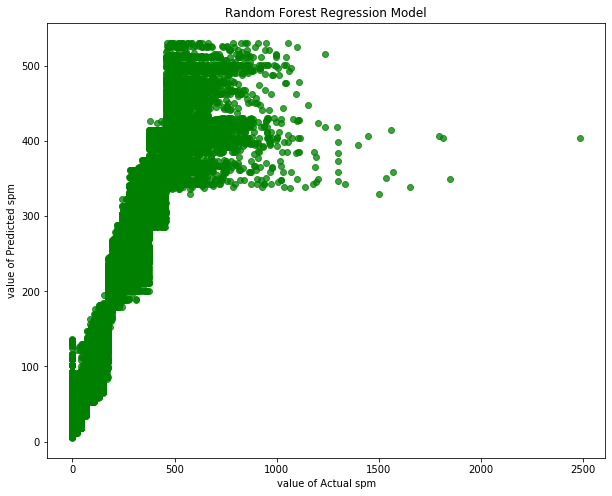

In [14]:
# view this relationship between predictions and actual_values graphically with a scatter plot.

rf_PriceArr = np.array(rf_test_results.select('spm').collect())
rf_PredictionArr = np.array(rf_test_results.select('Prediction').collect())

plt.figure(figsize=(10,8))
plt.scatter(rf_PriceArr,rf_PredictionArr, alpha=.75,
            color='g')  # alpha helps to show overlapping data
plt.xlabel('value of Actual spm')
plt.ylabel('value of Predicted spm')
plt.title('Random Forest Regression Model')

plt.show()


In [15]:
# Evaluate model
rf_cv_evaluator = RegressionEvaluator(metricName="rmse", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())

# Create ParamGrid for Cross Validation
rf_paramGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.maxBins, [10, 20, 40])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.numTrees, [10, 100])
             .build())

# Create 5-fold CrossValidator
rf_cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rf_paramGrid,
                      evaluator = rf_cv_evaluator,
                      numFolds = 5)
# creating the pipeline with cross validator and features
rf_cv_pipeline = Pipeline(stages=[assembler, rf_cv])

# fitting the train data 
rf_cv_pipelineModel = rf_cv_pipeline.fit(train_data)


In [16]:
# Useing the model on train data to view the result of the model on train data

rf_cv_train_results = rf_cv_pipelineModel.transform(train_data)

# Let's have a look into the predictions on the traindata from model.
rf_cv_train_results.select('spm','prediction', 'patterns').show(10)


rf_cv_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on train data = %g" %rf_cv_evaluator.evaluate(rf_cv_train_results,{rf_cv_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on train data = %g" %rf_cv_evaluator.evaluate(rf_cv_train_results,{rf_cv_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on train data = %g" %rf_cv_evaluator.evaluate(rf_cv_train_results,{rf_cv_evaluator.metricName: "rmse"}))

print("R Squared (R2) on train data = %g" %rf_cv_evaluator.evaluate(rf_cv_train_results,{rf_cv_evaluator.metricName: "r2"}))


+---+-----------------+--------------------+
|spm|       prediction|            patterns|
+---+-----------------+--------------------+
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
+---+-----------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on train data = 21.6538
Mean Squared Error (mse) on train data = 1820.59
Root Mean Squared Error (rmse) on train data = 42.6684
R Squared (R2) on train data = 0.919125


In [17]:
# Use test set here so we can measure the accuracy of our model on new data

rf_cv_test_results = rf_cv_pipelineModel.transform(test_data)


# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
rf_cv_test_results.select('spm','prediction', 'patterns').show(10)


rf_cv_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "rmse"}))

print("R Squared (R2) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "r2"}))



+---+-----------------+--------------------+
|spm|       prediction|            patterns|
+---+-----------------+--------------------+
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|62.52787429132465|(50,[4,16],[1.0,1...|
|  0|62.52787429132465|(50,[4,16],[1.0,1...|
|  0|40.21634966770892|(50,[7,16],[1.0,1...|
+---+-----------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data = 21.5335
Mean Squared Error (mse) on test data = 1731.95
Root Mean Squared Error (rmse) on test data = 41.6167
R Squared (R2) on test data = 0.923157


In [18]:
# Use test set here so we can measure the accuracy of our model on new data

rf_cv_test_results = rf_cv_pipelineModel.transform(test_data)


# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
rf_cv_test_results.select('spm','prediction', 'patterns').show(10)


rf_cv_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "rmse"}))

print("R Squared (R2) on test data = %g" %rf_cv_evaluator.evaluate(rf_cv_test_results,{rf_cv_evaluator.metricName: "r2"}))



+---+-----------------+--------------------+
|spm|       prediction|            patterns|
+---+-----------------+--------------------+
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|15.35788917342578|(50,[2,16],[1.0,1...|
|  0|62.52787429132465|(50,[4,16],[1.0,1...|
|  0|62.52787429132465|(50,[4,16],[1.0,1...|
|  0|40.21634966770892|(50,[7,16],[1.0,1...|
+---+-----------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data = 21.5335
Mean Squared Error (mse) on test data = 1731.95
Root Mean Squared Error (rmse) on test data = 41.6167
R Squared (R2) on test data = 0.923157


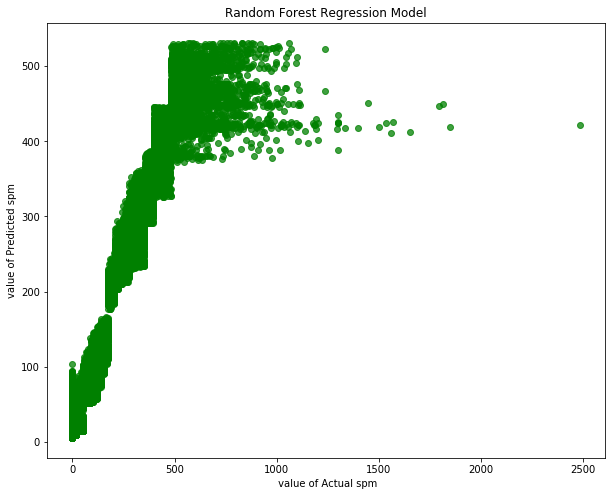

In [19]:
# view this relationship between predictions and actual_values graphically with a scatter plot.

rf_cv_PriceArr = np.array(rf_cv_test_results.select('spm').collect())
rf_cv_PredictionArr = np.array(rf_cv_test_results.select('Prediction').collect())

plt.figure(figsize=(10,8))
plt.scatter(rf_cv_PriceArr,rf_cv_PredictionArr, alpha=.75,
            color='g')  # alpha helps to show overlapping data
plt.xlabel(' value of Actual spm')
plt.ylabel('value of Predicted spm')
plt.title('Random Forest Regression Model')

plt.show()

In [20]:
# Gradient Boosting Tree Regression starts here

from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# train RandomForest model
gbr = GBTRegressor(labelCol="spm", featuresCol="patterns", predictionCol = "prediction")

gbr_pipeline = Pipeline(stages=[assembler, gbr])

#Creating the model for Gradient Boosting Tree Regression

gbr_model = gbr_pipeline.fit(train_data)
# Useing the model on train data to view the result of the model on train data

gbr_train_results = gbr_model.transform(train_data)


In [21]:
# Let's have a look into the predictions on the traindata from model.
gbr_train_results.select('spm','prediction', 'patterns').show(10)


gbr_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on train data = %g" %gbr_evaluator.evaluate(gbr_train_results,{gbr_evaluator .metricName: "mae"}))

print("Mean Squared Error (mse) on train data = %g" %gbr_evaluator.evaluate(gbr_train_results,{gbr_evaluator .metricName: "mse"}))

print("Root Mean Squared Error (rmse) on train data = %g" %gbr_evaluator.evaluate(gbr_train_results,{gbr_evaluator .metricName: "rmse"}))

print("R Squared (R2) on train data = %g" %gbr_evaluator.evaluate(gbr_train_results,{gbr_evaluator.metricName: "r2"}))



+---+--------------------+--------------------+
|spm|          prediction|            patterns|
+---+--------------------+--------------------+
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
+---+--------------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on train data = 6.172
Mean Squared Error (mse) on train data = 602.556
Root Mean Squared Error (rmse) on train data = 24.547
R Squared (R2) on train data = 0.973233


In [22]:
# Make predictions on test data
gbr_test_results = gbr_model.transform(test_data)

# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
gbr_test_results.select('spm','prediction', 'patterns').show(10)


gbr_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on test data = %g" %gbr_evaluator.evaluate(gbr_test_results,{gbr_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on test data = %g" %gbr_evaluator.evaluate(gbr_test_results,{gbr_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on test data = %g" %gbr_evaluator.evaluate(gbr_test_results,{gbr_evaluator.metricName: "rmse"}))

print("R Squared (R2) on test data = %g" %gbr_evaluator.evaluate(gbr_test_results,{gbr_evaluator.metricName: "r2"}))



+---+--------------------+--------------------+
|spm|          prediction|            patterns|
+---+--------------------+--------------------+
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[2,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[4,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[4,16],[1.0,1...|
|  0|-0.01530301793662854|(50,[7,16],[1.0,1...|
+---+--------------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data = 6.21342
Mean Squared Error (mse) on test data = 596.464
Root Mean Squared Error (rmse) on test data = 24.4226
R Squared (R2) on test data = 0.973536


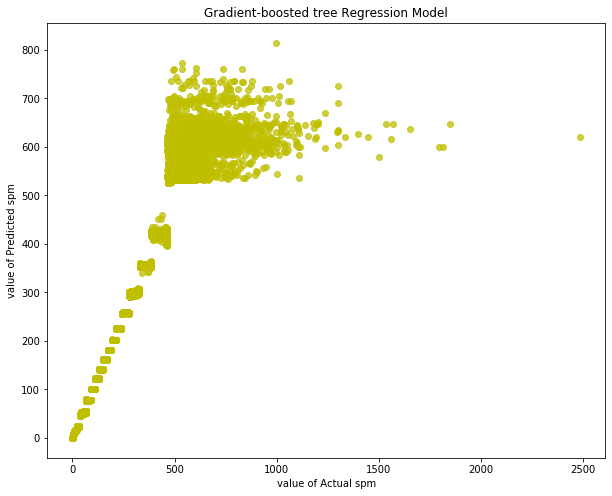

In [23]:
# view this relationship between predictions and actual_values graphically with a scatter plot.

gbr_PriceArr = np.array(gbr_test_results.select('spm').collect())
gbr_PredictionArr = np.array(gbr_test_results.select('Prediction').collect())

plt.figure(figsize=(10,8))
plt.scatter(gbr_PriceArr,gbr_PredictionArr, alpha=.75,
            color='y')  # alpha helps to show overlapping data
plt.xlabel('value of Actual spm')
plt.ylabel('value of Predicted spm')
plt.title('Gradient-boosted tree Regression Model')

plt.show()


In [24]:
# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
#  - maxIter: iterations, i.e., number of trees in each GBT ensemble
# In this example notebook, we keep these values small.
#In practice, to get the highest accuracy, we would likely want to try deeper trees (10 or higher) and 
#more trees in the ensemble (>100).
gbr_paramGrid = ParamGridBuilder()\
  .addGrid(gbr.maxDepth, [2, 5])\
  .addGrid(gbr.maxIter, [10, 100])\
  .build()
# We define an evaluation metric.  
#This tells CrossValidator how well we are doing by comparing the true labels with predictions.
gbr_cv_evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbr.getLabelCol(), predictionCol=gbr.getPredictionCol())
# Declare the CrossValidator, which runs model tuning for us.
gbr_cv = CrossValidator(estimator=gbr, evaluator=gbr_cv_evaluator, estimatorParamMaps=gbr_paramGrid)
#creating pipeline with the features and model
gbr_cv_pipeline = Pipeline(stages=[assembler, gbr_cv])

# fitting the train data and transforming the test data

gbr_cv_pipelineModel = gbr_cv_pipeline.fit(train_data)



In [25]:
# Useing the model on train data to view the result of the model on train data

gbr_cv_train_results = gbr_cv_pipelineModel.transform(train_data)

gbr_cv_train_results.select('spm','prediction', 'patterns').show(10)

gbr_cv_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on train data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_train_results,{gbr_cv_evaluator .metricName: "mae"}))

print("Mean Squared Error (mse) on train data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_train_results,{gbr_cv_evaluator .metricName: "mse"}))

print("Root Mean Squared Error (rmse) on train data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_train_results,{gbr_cv_evaluator .metricName: "rmse"}))

print("R Squared (R2) on train data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_train_results,{gbr_cv_evaluator.metricName: "r2"}))


+---+--------------------+--------------------+
|spm|          prediction|            patterns|
+---+--------------------+--------------------+
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
+---+--------------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on train data = 5.59635
Mean Squared Error (mse) on train data = 495.473
Root Mean Squared Error (rmse) on train data = 22.2592
R Squared (R2) on train data = 0.97799


In [26]:
# using the model to get prediction on test data
gbr_cv_test_results = gbr_cv_pipelineModel.transform(test_data)


# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
gbr_cv_test_results.select('spm','prediction', 'patterns').show(10)

gbr_cv_evaluator = RegressionEvaluator(labelCol = "spm")
print("Mean Absolute Error (mae) on test data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_test_results,{gbr_cv_evaluator.metricName: "mae"}))

print("Mean Squared Error (mse) on test data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_test_results,{gbr_cv_evaluator.metricName: "mse"}))

print("Root Mean Squared Error (rmse) on test data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_test_results,{gbr_cv_evaluator.metricName: "rmse"}))

print("R Squared (R2) on test data = %g" %gbr_cv_evaluator.evaluate(gbr_cv_test_results,{gbr_cv_evaluator.metricName: "r2"}))

+---+--------------------+--------------------+
|spm|          prediction|            patterns|
+---+--------------------+--------------------+
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[2,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[4,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[4,16],[1.0,1...|
|  0|-0.01517651240117...|(50,[7,16],[1.0,1...|
+---+--------------------+--------------------+
only showing top 10 rows

Mean Absolute Error (mae) on test data = 5.78034
Mean Squared Error (mse) on test data = 566.159
Root Mean Squared Error (rmse) on test data = 23.7941
R Squared (R2) on test data = 0.974881


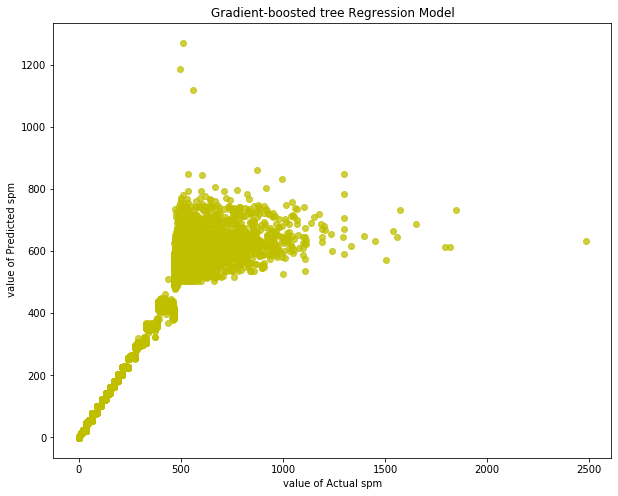

In [27]:
# view this relationship between predictions and actual_values graphically with a scatter plot.

gbr_cv_PriceArr = np.array(gbr_cv_test_results.select('spm').collect())
gbr_cv_PredictionArr = np.array(gbr_cv_test_results.select('Prediction').collect())

plt.figure(figsize=(10,8))
plt.scatter(gbr_cv_PriceArr,gbr_cv_PredictionArr, alpha=.75,
            color='y')  # alpha helps to show overlapping data
plt.xlabel('value of Actual spm')
plt.ylabel(' value of Predicted spm')
plt.title('Gradient-boosted tree Regression Model')

plt.show()
